In [67]:
"""
Lagrangian DA for the 2-layer QG system
"""

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
from Lagrange_tracer import Lagrange_tracer_model
import h5py
from scipy import sparse

# fix the random seed
np.random.seed(2024)


# load data

In [138]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_beta22_K16.mat'
with h5py.File(data_path, 'r') as file:
#     print("Keys: %s" % file.keys())
    psi1_hat_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
#     psi2_hat_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
#     s_rate = file['s_rate'][()][0,0]
    params_dataset = file['params']
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = file['topo'][()]
# dt = dt * s_rate
print('psi_hat_t.shape',psi1_hat_t.shape)
psi1_hat_t = psi1_hat_t['real'] + 1j * psi1_hat_t['imag']
# psi2_hat_t = psi2_hat_t['real'] + 1j * psi2_hat_t['imag']
print('psi_hat_t.dtype',psi1_hat_t.dtype)

psi_hat_t.shape (16, 16, 100000)
psi_hat_t.dtype complex128


# generate tracer observations

In [191]:
# run obs model
L = 256 # number of tracers
K = psi1_hat_t.shape[0]
N = 100000 #psi1_hat_t.shape[2]
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
sigma_xy = 0.01
x0 = np.random.uniform(-np.pi, np.pi, L)
y0 = np.random.uniform(-np.pi, np.pi, L)

# run model
model = Lagrange_tracer_model(N, L, kx, ky, psi1_hat_t, dt, sigma_xy, x0, y0, interv=1)
xt, yt, ut, vt = model.forward()   

In [192]:
# save data
obs = {
    'xt': xt,
    'yt': yt,
    'ut': ut,
    'vt': vt,
    'sigma_xy': sigma_xy,
    'L': L,
    'dt': dt
}
np.savez('../data/obs_K16.npz', **obs)

# Lagrangian DA

In [193]:
# load data
obs = np.load('../data/obs_K16.npz')
xt = obs['xt']
yt = obs['yt']
L = obs['L'].item()
dt = obs['dt'].item()
sigma_xy = obs['sigma_xy'].item()
dt = obs['dt'].item()
params = np.load('../data/est_paras_ou_K16_beta22.npy', allow_pickle=True).item()
gamma, omega, f, sigma = params['gamma'], params['omega'], params['f'], params['sigma']
eigens = np.load('../data/eigens_K16_beta22.npy', allow_pickle=True)
omega1 = eigens.item()['omega1']
omega2 = eigens.item()['omega2']
r1 = eigens.item()['r1']
r2 = eigens.item()['r2']
file = np.load('../data/psi_k_truth_K16_beta22.npz') # obtain the true underlying flow ($\boldsymbol{\Psi}^\bot$)
psi_t_k = file['psi_t_k']
tau_t_k = file['tau_t_k']
cut = file['cut'].item()

In [194]:
# Lagrangian DA
def truncate(kk, cut):
    '''require the input kk has shape (K,) or (K,K,...)'''
    K = kk.shape[0]

    if kk.ndim == 1:
        index_to_remove = np.zeros(K, dtype=bool)
        index_to_remove[(K//2-cut):(K//2+cut+1)] = True
    elif kk.ndim > 1:
        index_to_remove = np.zeros_like(kk, dtype=bool)
        index_to_remove[(K//2-cut):(K//2+cut+1), :] = True
        index_to_remove[:, (K//2-cut):(K//2+cut+1)] = True
        new_shape = np.array(kk.shape)
        new_shape[:2] -= (2*cut+1)

    return kk[~index_to_remove].reshape(new_shape)

def get_A(x,y,K,r1,r2,cut):
    L = x.shape[0]
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    KX, KY = np.meshgrid(kx, ky)
    KX = truncate(KX, cut)
    KY = truncate(KY, cut)
    r1 = truncate(r1[:,:,0], cut)
    r2 = truncate(r2[:,:,0], cut)
    E = np.zeros((2*L, (K-2*cut-1)**2), dtype=np.complex_)

    exp_term = np.exp(1j * x[:,None] @ KX.flatten(order='F')[None,:] + 1j * y[:,None] @ KY.flatten(order='F')[None,:])
    E[:L,:] = exp_term * (1j) * KY.flatten(order='F')
    E[L:,:] = exp_term * (-1j) * KX.flatten(order='F')
#     R_bot = sparse.hstack([sparse.diags(r1.flatten(order='F')), sparse.diags(r2.flatten(order='F'))], format="csr")
#     A = sparse.csr_matrix(E).dot(R_bot)
    R_bot = np.hstack([np.diag(r1.flatten(order='F')), np.diag(r2.flatten(order='F'))])
    A = E @ R_bot / K**2

    return A


N = 80000
# Sigma1 = np.array(sigma_xy)[None, None]
# invBoB = np.linalg.inv(Sigma1 @ Sigma1.T)
InvBoB = 1 / sigma_xy**2
mu0 = np.concatenate((truncate(psi_t_k[:,:,0],cut).flatten(order='F'), truncate(tau_t_k[:,:,0],cut).flatten(order='F'))) # assume the initial condition is truth
n = mu0.shape[0]
R0 = np.zeros((n, n))
mu_t = np.zeros((n, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((n, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements
a0 = truncate(f,cut).flatten(order='F')
a1 = -np.diag(truncate(gamma,cut).flatten(order='F')) + 1j * np.diag(truncate(omega,cut).flatten(order='F'))
Sigma_u = np.diag(truncate(sigma,cut).flatten(order='F'))
x = xt
y = yt

for i in range(1, N):
    x0 = x[:, i - 1]
    y0 = y[:, i - 1]
    x1 = x[:, i]
    y1 = y[:, i]
    x_diff = x1 - x0
    y_diff = y1 - y0

    # Need to take into account the periodic boundary conditions
    x_diff[x_diff > np.pi] = x_diff[x_diff > np.pi] - 2 * np.pi
    x_diff[x_diff < -np.pi] = x_diff[x_diff < -np.pi] + 2 * np.pi
    y_diff[y_diff > np.pi] = y_diff[y_diff > np.pi] - 2 * np.pi
    y_diff[y_diff < -np.pi] = y_diff[y_diff < -np.pi] + 2 * np.pi

    # Matrix for filtering
    A1 = get_A(x0, y0, K, r1, r2, cut)
    
    # Update the posterior mean and posterior covariance
    mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (np.hstack((x_diff, y_diff)) - A1 @ mu0 * dt)
    R = R0 + (a1 @ R0 + R0 @ a1.conj().T + Sigma_u @ Sigma_u.conj().T - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
    R_t[:, i] = np.diag(R)
    mu0 = mu
    R0 = R


In [195]:
def mu2psi(mu_t, K, cut):
    n = K-cut*2-1
    mu_t = mu_t.reshape((n,n,2,-1), order='F')
    psi_k = mu_t[:,:,0]
    tau_k = mu_t[:,:,1]
    
    return psi_k, tau_k

psi_k_pos, tau_k_pos = mu2psi(mu_t, K, cut)


In [196]:
psi_t_k.shape

(16, 16, 80000)

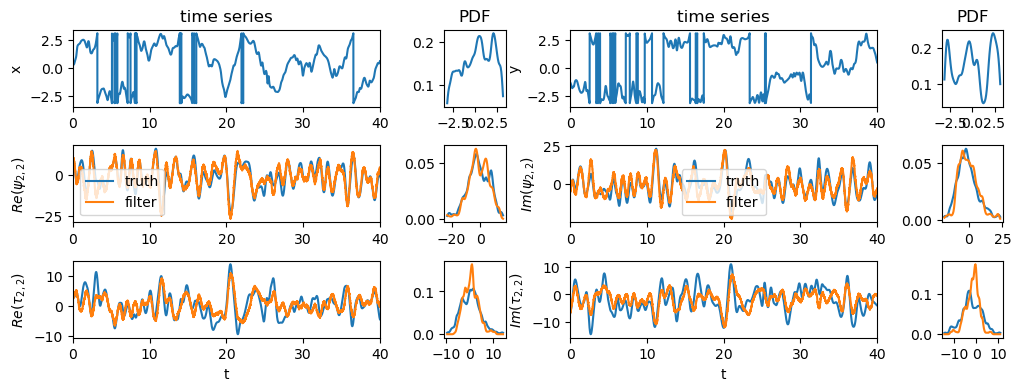

In [197]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,4))
widths = [5, 1, 5, 1]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[2, 2])
ax44 = fig.add_subplot(spec[0, 3])
ax55 = fig.add_subplot(spec[1, 3])
ax66 = fig.add_subplot(spec[2, 3])

# plot time series
ax1.plot(xaxis, xt[0,sel0:sel1:interv], label='x')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('x')
ax1.set_title('time series')

ax2.plot(xaxis, psi_t_k[iky,ikx,sel0:sel1:interv].real, label='truth')
ax2.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].real, label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel('$Re(\psi_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.legend()

ax3.plot(xaxis, tau_t_k[iky,ikx,sel0:sel1:interv].real, label='truth')
ax3.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].real, label='filter')
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_ylabel(r'$Re(\tau_{{{:d},{:d}}})$'.format(ikx, iky))
ax3.set_xlabel('t')

# plot pdf
samples = xt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p)
ax4.set_title('PDF')

samples = psi_t_k[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, label='truth')
samples = psi_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, label='filter')

samples = tau_t_k[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, label='truth')
samples = tau_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, label='filter')

ax11.plot(xaxis, yt[0,sel0:sel1:interv])
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('y')
ax11.set_title('time series')

ax22.plot(xaxis, psi_t_k[iky,ikx,sel0:sel1:interv].imag, label='truth')
ax22.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].imag, label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel('$Im(\psi_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.legend()

ax33.plot(xaxis, tau_t_k[iky,ikx,sel0:sel1:interv].imag, label='truth')
ax33.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].imag, label='filter')
ax33.set_xlim(sel0*dt, sel1*dt)
ax33.set_ylabel(r'$Im(\tau_{{{:d},{:d}}})$'.format(ikx, iky))
ax33.set_xlabel('t')

# plot pdf
samples = yt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p)
ax44.set_title('PDF')

samples = psi_t_k[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, label='truth')
samples = psi_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, label='filter')

samples = tau_t_k[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, label='truth')
samples = tau_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, label='filter')
# plt.savefig('./Lagrangian_DA/LagDA_K16_L64.png',dpi=100)
plt.show()

In [ ]:
R_psi_k_pos, R_tau_k_pos = mu2psi(R_t, K, cut)
plt.figure(figsize=(5,4))
plt.plot(R_psi_k_pos[ikx,ikx,:])
plt.xlabel('t')
plt.ylabel(r'$variance_{{{:d},{:d}}}$'.format(ikx, iky))
# plt.savefig('./Lagrangian_DA/var_L64.png')
plt.show()

In [87]:
psi_t_k.dtype

dtype('complex128')

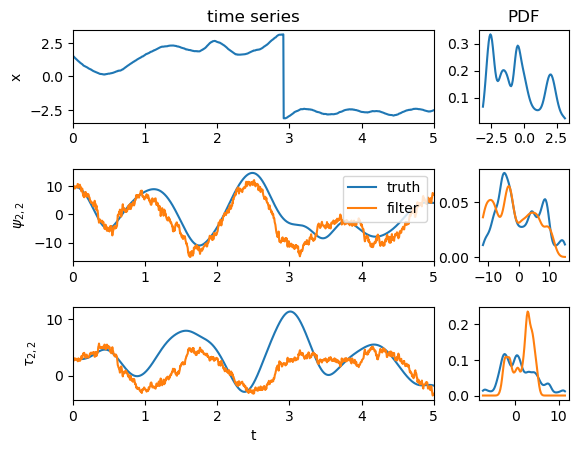

In [84]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure()
widths = [8, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=2, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.2, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])

# plot time series
ax1.plot(xaxis, xt[0,sel0:sel1:interv])
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('x')
ax1.set_title('time series')

ax2.plot(xaxis, psi_t_k[iky,ikx,sel0:sel1:interv], label='truth')
ax2.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv], label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel('$\psi_{{{:d},{:d}}}$'.format(ikx, iky))
ax2.legend()

ax3.plot(xaxis, tau_t_k[iky,ikx,sel0:sel1:interv], label='truth')
ax3.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv], label='filter')
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_ylabel(r'$\tau_{{{:d},{:d}}}$'.format(ikx, iky))
ax3.set_xlabel('t')

# plot pdf
samples = xt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p)
ax4.set_title('PDF')

samples = psi_t_k[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, label='truth')
samples = psi_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, label='filter')

samples = tau_t_k[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, label='truth')
samples = tau_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, label='filter')
plt.savefig('./Lagrangian_DA/LagDA_K16_L64.png',dpi=100)
plt.show()